## -> For Test Set

In [1]:
import mxnet as mx
import numpy as np
from mxnet import Context, cpu, gpu
from mxnet.ndarray import concat, stack

from generator_vgg import Generator
from discriminator import Discriminator
from util import Device
import modules

from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
from glob import glob

In [2]:
runname = 'sub18_VIS_Case1_1619741441'

In [3]:
sub_id = '18'
case = '1'
roi = 'VIS'

In [4]:
in_chan = 5
batch_size = 8
device = Device.CPU
context = cpu() if device.value == -1 else gpu(device.value)

## # Part 1: Outputs 

In [5]:
with Context(context):
    test_iter = modules.make_iterator_preprocessed('testing', sub_id, roi, case, batch_size=batch_size, shuffle=False) # shuffle=True
    
    RFlocs_VIS_overlapped_avg = modules.get_RFs(sub_id, roi, context)

    discriminator = Discriminator(in_chan)
    generator = Generator(in_chan, context)
    generator.network.load_parameters(f'saved_models/{runname}/netG_final.model', ctx=context)
    d = discriminator.network
    g = generator.network
    
    for RFsignalsVIS, targets in test_iter:
            # -------
            # Inputs
            # -------
            inputs_test = modules.get_inputsROI(RFsignalsVIS, RFlocs_VIS_overlapped_avg, context)

            # -----
            # Targets
            # -----            
            targets_test = targets.as_in_context(context)

            # ----
            # sample randomly from history buffer (capacity 50) 
            # ----

            outputs = g(inputs_test)
            
outputs_np = outputs.asnumpy()
targets_np = targets_test.asnumpy()
inputs_np = inputs_test.asnumpy()

## # Part 2: Make Video

### Frames

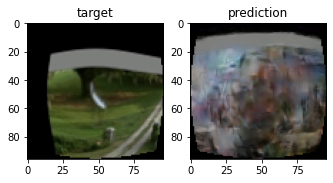

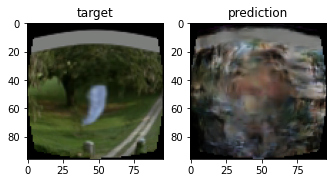

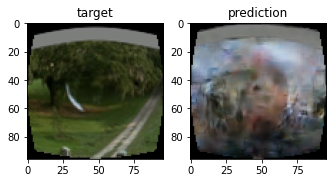

In [6]:
for batch_i in range(3):
    plt.figure(figsize = (20,5))
    plt.subplot(1,7,1)
    plt.title('target')
    plt.imshow(targets_np[batch_i].transpose(1,2,0))
    plt.subplot(1,7,2)
    plt.title('prediction')
    plt.imshow(outputs_np[batch_i].transpose(1,2,0))

### Make the Video

In [7]:
out_frames = []
target_frames = []
input_frames = []

with Context(context):
    test_iter = modules.make_iterator_preprocessed('testing', sub_id, roi, case, batch_size=batch_size, shuffle=False) # shuffle=True
    
    RFlocs_VIS_overlapped_avg = modules.get_RFs(sub_id, roi, context)

    discriminator = Discriminator(in_chan)
    generator = Generator(in_chan, context)
    generator.network.load_parameters(f'saved_models/{runname}/netG_final.model', ctx=context)
    d = discriminator.network
    g = generator.network
    
    for RFsignalsVIS, targets in tqdm(test_iter):
        # -------
        # Inputs
        # -------
        inputs_test = modules.get_inputsROI(RFsignalsVIS, RFlocs_VIS_overlapped_avg, context)

        # -----
        # Targets
        # -----            
        targets_test = targets.as_in_context(context)

        # ----
        # sample randomly from history buffer (capacity 50) 
        # ----

        outputs = g(inputs_test)

        outputs_np = outputs.asnumpy()
        targets_np = targets_test.asnumpy()
        inputs_np = inputs_test.asnumpy()

        out_frames.append(outputs_np)
        target_frames.append(targets_np)
        input_frames.append(inputs_np)
        
out_video_np = np.concatenate(out_frames)
target_video_np = np.concatenate(target_frames)
brain_signal_np = np.concatenate(input_frames)

100%|██████████| 41/41 [00:10<00:00,  3.81it/s]


In [8]:
out_video_np_transposed = (out_video_np*255).transpose(0,2,3,1).astype('uint8')
target_video_np_transposed = (target_video_np.transpose(0,2,3,1)*255).astype('uint8')

brain_signal_np_mean = brain_signal_np.mean(axis=1)
brain_signal_np_mean = (brain_signal_np_mean*255).astype('uint8')

whole_video = np.concatenate((brain_signal_np_mean[:,:,:, np.newaxis].repeat(3, 3), 
                              out_video_np_transposed, target_video_np_transposed), axis = 2)

In [9]:
set_t = 'testing'

imageio.mimwrite(f'logs/{runname}/out_video_{set_t}.mp4', out_video_np_transposed)
imageio.mimwrite(f'logs/{runname}/target_video_{set_t}.mp4', target_video_np_transposed)
imageio.mimwrite(f'logs/{runname}/brain_signal_mean_{set_t}.mp4', brain_signal_np_mean)
imageio.mimwrite(f'logs/{runname}/whole_video_{set_t}.mp4', whole_video)

In [10]:
reader = imageio.get_reader(f'logs/{runname}/whole_video_{set_t}.mp4')
fps = 0.5
writer = imageio.get_writer(f'logs/{runname}/fps{fps}_whole_video_{set_t}.mp4', fps=fps)

for im in reader:
    writer.append_data(im[:, :, :])
writer.close()

## -> For Training Set

## # Part 1: Outputs 

In [11]:
with Context(context):
    train_iter = modules.make_iterator_preprocessed('training', sub_id, roi, case, batch_size=batch_size, shuffle=False, fraction=0.2) # shuffle=True
    
    RFlocs_VIS_overlapped_avg = modules.get_RFs(sub_id, roi, context)

    discriminator = Discriminator(in_chan)
    generator = Generator(in_chan, context)
    generator.network.load_parameters(f'saved_models/{runname}/netG_final.model', ctx=context)
    d = discriminator.network
    g = generator.network
    
    for RFsignalsVIS, targets in train_iter:
            # -------
            # Inputs
            # -------
            inputs_test = modules.get_inputsROI(RFsignalsVIS, RFlocs_VIS_overlapped_avg, context)

            # -----
            # Targets
            # -----            
            targets_test = targets.as_in_context(context)

            # ----
            # sample randomly from history buffer (capacity 50) 
            # ----

            outputs = g(inputs_test)
            
outputs_np = outputs.asnumpy()
targets_np = targets_test.asnumpy()
inputs_np = inputs_test.asnumpy()

## # Part 2: Make Video

### Frames

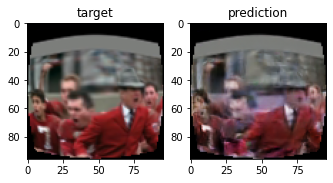

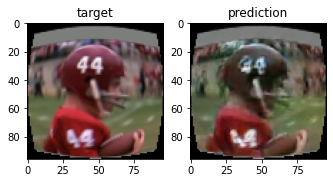

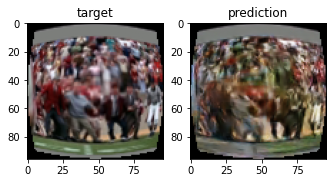

In [13]:
for batch_i in range(3):
    plt.figure(figsize = (20,5))
    plt.subplot(1,7,1)
    plt.title('target')
    plt.imshow(targets_np[batch_i].transpose(1,2,0))
    plt.subplot(1,7,2)
    plt.title('prediction')
    plt.imshow(outputs_np[batch_i].transpose(1,2,0))

### Make the Video

In [14]:
out_frames = []
target_frames = []
input_frames = []

with Context(context):
    train_iter = modules.make_iterator_preprocessed('training', sub_id, roi, case, batch_size=batch_size, shuffle=False, fraction=0.2) # shuffle=True
    
    RFlocs_VIS_overlapped_avg = modules.get_RFs(sub_id, roi, context)

    discriminator = Discriminator(in_chan)
    generator = Generator(in_chan, context)
    generator.network.load_parameters(f'saved_models/{runname}/netG_final.model', ctx=context)
    d = discriminator.network
    g = generator.network
    
    for RFsignalsVIS, targets in tqdm(train_iter):
        # -------
        # Inputs
        # -------
        inputs_test = modules.get_inputsROI(RFsignalsVIS, RFlocs_VIS_overlapped_avg, context)

        # -----
        # Targets
        # -----            
        targets_test = targets.as_in_context(context)

        # ----
        # sample randomly from history buffer (capacity 50) 
        # ----

        outputs = g(inputs_test)

        outputs_np = outputs.asnumpy()
        targets_np = targets_test.asnumpy()
        inputs_np = inputs_test.asnumpy()

        out_frames.append(outputs_np)
        target_frames.append(targets_np)
        input_frames.append(inputs_np)
        
out_video_np = np.concatenate(out_frames)
target_video_np = np.concatenate(target_frames)
brain_signal_np = np.concatenate(input_frames)

100%|██████████| 80/80 [00:20<00:00,  3.99it/s]


In [15]:
out_video_np_transposed = (out_video_np*255).transpose(0,2,3,1).astype('uint8')
target_video_np_transposed = (target_video_np.transpose(0,2,3,1)*255).astype('uint8')

brain_signal_np_mean = brain_signal_np.mean(axis=1)
brain_signal_np_mean = (brain_signal_np_mean*255).astype('uint8')

whole_video = np.concatenate((brain_signal_np_mean[:,:,:, np.newaxis].repeat(3, 3), 
                              out_video_np_transposed, target_video_np_transposed), axis = 2)

In [16]:
set_t = 'training'

imageio.mimwrite(f'logs/{runname}/out_video_{set_t}.mp4', out_video_np_transposed)
imageio.mimwrite(f'logs/{runname}/target_video_{set_t}.mp4', target_video_np_transposed)
imageio.mimwrite(f'logs/{runname}/brain_signal_mean_{set_t}.mp4', brain_signal_np_mean)
imageio.mimwrite(f'logs/{runname}/whole_video_{set_t}.mp4', whole_video)

In [17]:
reader = imageio.get_reader(f'logs/{runname}/whole_video_{set_t}.mp4')
fps = 0.5
writer = imageio.get_writer(f'logs/{runname}/fps{fps}_whole_video_{set_t}.mp4', fps=fps)

for im in reader:
    writer.append_data(im[:, :, :])
writer.close()